# Yolov1_tutorial
## 写在前面
本文参考了诸多非常良好的博客，论文，不能一一列举。主要列举以下几个比较优秀的博客和论文。可以阅读它们对Yolov1的原理更加深入地理解。

* https://www.paddlepaddle.org.cn/tutorials/projectdetail/3796400 目标检测的基础概念，介绍了什么是锚框(anchor box)，什么是GT(ground truth)，什么是交并比(IOU)等
* https://zhuanlan.zhihu.com/p/364367221 在知乎专栏，详细介绍了YOLOv1原理
* Redmon J, Divvala S, Girshick R, et al. You only look once: Unified, real-time object detection[C]//Proceedings of the IEEE conference on computer vision and pattern recognition. 2016: 779-788. YOLOv1源论文

本次数据集使用了飞桨社区提供的移动机器人数据集，其实就是Robomaster比赛的机器人。

# 1.准备数据集

> 挂载到google云盘

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

> 下载数据集

* 注：文件大小大约为2.3G

In [ ]:
!wget -O /content/mobile-robot-detection-dataset.zip "https://bj.bcebos.com/ai-studio-online/5df19b60ccd742aa890485aa93ab37f0bd426134f4df482aa99bd13eb9dcd651?authorization=bce-auth-v1%2F5cfe9a5e1454405eb2a975c43eace6ec%2F2022-09-04T15%3A27%3A23Z%2F-1%2F%2F22930e9e4113c3811d89586bf98525f6189ac43046dbc14c668465415db537c6&responseContentDisposition=attachment%3B%20filename%3Dmobile-robot-detection-dataset.zip"

--2023-02-13 02:13:46--  https://bj.bcebos.com/ai-studio-online/5df19b60ccd742aa890485aa93ab37f0bd426134f4df482aa99bd13eb9dcd651?authorization=bce-auth-v1%2F5cfe9a5e1454405eb2a975c43eace6ec%2F2022-09-04T15%3A27%3A23Z%2F-1%2F%2F22930e9e4113c3811d89586bf98525f6189ac43046dbc14c668465415db537c6&responseContentDisposition=attachment%3B%20filename%3Dmobile-robot-detection-dataset.zip
Resolving bj.bcebos.com (bj.bcebos.com)... 103.235.46.61, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to bj.bcebos.com (bj.bcebos.com)|103.235.46.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2486484950 (2.3G) [application/octet-stream]
Saving to: ‘/content/mobile-robot-detection-dataset.zip’

n-dataset.zip         0%[                    ]   1.33M   196KB/s    eta 5h 14m ^C


> 解压数据集

In [ ]:
!unzip -q /content/mobile-robot-detection-dataset.zip -d /content

[/content/mobile-robot-detection-dataset.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/mobile-robot-detection-dataset.zip or
        /content/mobile-robot-detection-dataset.zip.zip, and cannot find /content/mobile-robot-detection-dataset.zip.ZIP, period.


> 导入所需的包

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, BatchNorm2d
from torch import nn
from torch.utils import model_zoo

import cv2
import os
import os.path
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

> 定义所用设备

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# 2.数据集预处理

> 定义类别数

In [ ]:
CLASS_NUM = 5  # 类别数

> 定义数据集预处理类

* 假设网络实现的预测类别数为C个：论文中使用PASCAL VOC数据集，C=20，即实现20类物品的目标检测，这里我们使用mobile-robot-detection-dataset数据集，C=5，即实现5类物品的目标检测。
* 输入图像首先被resize到指定尺寸：论文中将输入图像统一调整到448×448，即网络输入448×448×3，这里我们按照论文来进行同样处理。
* 对图像进行划分，共划分为S×S个网格：论文中S=7，即共划分为7×7个网格，每个网格中包含64×64个像素点，这里我们按照论文来进行同样处理。
* 针对每个网格：
  * 生成C个类别目标的概率分数（表示该网格是否存在目标的概率），用p表示。
  * 生成B个检测框（即bbox，用于检测目标），每个检测框共5个参数(x, y, w, h, c):
    * 使用(x, y)表示检测框中心相对于网格左上方的偏移量。
    * 使用(w, h)表示检测框的宽和高，该值是相对于图像宽高的比。
    * 使用confident表示该框预测目标的置信度，该值综合了含目标的置信度和方框位置准确度。
* 针对一张图片：最终输出向量为S×S×(C+B×5)，论文中为7×7×(20+2×5)=1470，这里我们是7×7×(5+2×5)=735。
* 对输出向量进行后处理，得到最终结果。


In [ ]:
class yolov1Dataset(Dataset):
    image_size = 448  # 输入图片大小

    # 数据初始化
    def __init__(self, img_root, directory, train, transform):
        self.root = img_root  # 数据集存放绝对路径
        self.directory = directory  # 数据集存放相对路径
        self.train = train  # 是否进行数据增强
        self.transform = transform  # 对图像进行转化

        self.fnames = []  # 初始化数据集图像路径列表
        self.boxes = []  # 初始化数据集图像锚框信息列表
        self.labels = []  # 初始化数据集图像标签列表

        self.S = 7   # 图像分为7×7个网格
        self.B = 2   # 共2个预测框
        self.C = CLASS_NUM  # 共5个类别

        self.mean = (123, 117, 104)  # BGR均值

        for dic in self.directory:  # 遍历列表
            files = os.listdir(os.path.join(self.root, dic))  # 得到列表中文件夹的绝对路径
            for filename in files:  # 遍历列表中文件夹
                txt_path = os.path.join(self.root, dic, filename)  # 得到文件夹下的txt文件的绝对路径

                if not os.path.getsize(txt_path):  # 如果txt文件为空
                  continue  # 跳过

                jpg_path = os.path.join(self.root, dic.replace('labels', 'JPEGImages'), filename.replace('txt', 'jpg')) # 得到txt文件对应的jpg文件的绝对路径
                self.fnames.append(jpg_path)  # 将jpg文件的绝对路径放入fnames列表
                print(jpg_path)  # 打印jpg文件的绝对路径

                file_txt = open(txt_path)  # 打开txt文件

                lines = file_txt.readlines()  # 读取txt文件每一行

                label = []  # 初始化标签列表
                box = []  # 初始化锚框信息列表

                for line in lines:  # 逐行遍历txt文件
                    splited = line.strip().split() # 以空格分割每一行得到一个列表

                    label.append(float(splited[0]))  # 将列表的第1个数据追加到标签列表中，注意要转为float类型
                    box.append([float(splited[1]), float(splited[2]), float(splited[3]), float(splited[4])])  # 将列表的第2-5个数据追加到锚框信息列表中，注意要转为float类型


                self.labels.append(torch.LongTensor(label))  # 将一个jpg文件对应的标签列表追加到数据集标签列表中
                self.boxes.append(torch.Tensor(box))  # 将一个jpg文件对应的锚框信息列表追加到数据集锚框信息列表中

        self.num_samples = len(self.boxes)  # 将数据集boxes的长度作为数据集的长度

    # 数据处理
    def __getitem__(self, idx):
        fname = self.fnames[idx]  # 得到第idx个图像的绝对路径
        img = cv2.imread(fname)  # 读取第idx图像
        boxes = self.boxes[idx].clone()  # 得到支持梯度回溯的第idx个boxes
        labels = self.labels[idx].clone()  # 得到支持梯度回溯的第idx个labels

        if self.train:  # 进行数据增强，注意不能直接用torch自带的transform，因为对图片进行旋转等会造成boxes的坐标也发生变化，所以需要自己来定义数据增强
            img = self.randomBlur(img)  # 随机模糊
            img = self.RandomBrightness(img)  # 随机亮度
            img = self.RandomHue(img)  # 随机色调
            img = self.RandomSaturation(img)  # 随机饱和度

        img = self.BGR2RGB(img)  # 将BGR通道转为RGB通道，因为pytorch预训练模型用的是RGB通道
        img = self.subMean(img, self.mean)  # 减去均值
        img = cv2.resize(img, (self.image_size, self.image_size))  # 将所有图片裁剪为指定大小

        target = self.encoder(boxes, labels)  # 将boxes和labels编码到7x7*30的向量

        for t in self.transform:  # 对于每一种图像转化操作
            img = t(img)  # 进行图像转化

        return img, target  # 返回处理后的img和将boxes、labels编码后得到的target

    # 获取数据集长度
    def __len__(self):
        return self.num_samples  # 返回数据集长度

    # 将boxes和labels编码到7x7*15的张量
    def encoder(self, boxes, labels):
        grid_num = self.S  # 图像共划分为7×7个网格，每个网格有64×64个像素点
        target = torch.zeros((grid_num, grid_num, int(self.C + 10)))  # 将target初始化为7*7*15的张量
        cell_size = 1. / grid_num  # 每一网格大小为1/7
        wh = boxes[:, 2:] # 得到锚框的宽和高列表
        cxcy = boxes[:, :2] # 得到锚框的中心坐标列表

        for i in range(cxcy.size()[0]):  # 遍历锚框的中心坐标列表
            cxcy_sample = cxcy[i]  # 获取第i个锚框的中心坐标列表
            ij = (cxcy_sample / cell_size).ceil() - 1  # 得到该中心坐标位于第几个网格中

            target[int(ij[1]), int(ij[0]), 4] = 1  # 将第一个锚框的置信度初始化为1
            target[int(ij[1]), int(ij[0]), 9] = 1  # 将第二个锚框的置信度初始化为1
            target[int(ij[1]), int(ij[0]), int(labels[i]) + 10] = 1  # 将5个类别对应的概率初始化为1

            xy = ij * cell_size  # 得到中心点所在网格的左上坐标
            delta_xy = (cxcy_sample - xy) / cell_size  # 得到中心与中心点所在网格左上坐标的偏移量

            # 每一个网格有两个边框
            target[int(ij[1]), int(ij[0]), :2] = delta_xy  # x1, y1
            target[int(ij[1]), int(ij[0]), 2:4] = wh[i]  # w1, h1
            target[int(ij[1]), int(ij[0]), 5:7] = delta_xy  # x2, y2
            target[int(ij[1]), int(ij[0]), 7:9] = wh[i]  # w2, h2

        return target  # 返回boxes和labels编码得到的7x7*15的张量

    # 以下为数据增强操作

    # 将RGB编码的图像转为BGR编码的图像
    def BGR2RGB(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 将BGR编码的图像转为HSV编码的图像
    def BGR2HSV(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 将HSV编码的图像转为BGR编码的图像
    def HSV2BGR(self, img):
        return cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

    # 随机模糊
    def randomBlur(self, img):
        if random.random() < 0.5:
            img = cv2.blur(img, (5, 5))
        return img

    # 随机亮度
    def RandomBrightness(self, bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h, s, v = cv2.split(hsv)
            adjust = random.choice([0.5, 1.5])
            v = v * adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h, s, v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    # 随机色调
    def RandomHue(self, bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h, s, v = cv2.split(hsv)
            adjust = random.choice([0.5, 1.5])
            h = h * adjust
            h = np.clip(h, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h, s, v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    # 随机饱和度
    def RandomSaturation(self, bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h, s, v = cv2.split(hsv)
            adjust = random.choice([0.5, 1.5])
            s = s * adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h, s, v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    # 减去均值
    def subMean(self, img, mean):
        mean = np.array(mean, dtype=np.float32)
        img = img - mean
        return img

# 3.定义损失

* 损失即计算网络输出值（或预测值）与标签值差异的程度。
* yolov1中损失函数共包含3项：（均采用均方误差实现）
  * 坐标预测损失

  \begin{array}{l}
  \lambda_{\text {coord }} \sum_{i=0}^{S^{2}} \sum_{j=0}^{B} \mathbb{1}_{i j}^{\text {obj }}\left[\left(x_{i}-\hat{x}_{i}\right)^{2}+\left(y_{i}-\hat{y}_{i}\right)^{2}\right]\\
  +\lambda_{\text {coord }} \sum_{i=0}^{S^{2}} \sum_{j=0}^{B} \mathbb{1}_{i j}^{\text {obj }}\left[\left(\sqrt{w_{i}}-\sqrt{\hat{w}_{i}}\right)^{2}+\left(\sqrt{h_{i}}-\sqrt{\hat{h}_{i}}\right)^{2}\right]\\
  \end{array}
  * 置信度预测损失（有中心点网格损失+无中心点网格损失）
  \begin{array}{l}
  \sum_{i=0}^{S^{2}} \sum_{j=0}^{B} \mathbb{1}_{i j}^{\text {obj }}\left(C_{i}-\hat{C}_{i}\right)^{2}\\+
  \lambda_{\text {noobj }} \sum_{i=0}^{S^{2}} \sum_{j=0}^{B} \mathbb{1}_{i j}^{\text {noobj }}\left(C_{i}-\hat{C}_{i}\right)^{2}\\
  \end{array}
  * 类别预测损失

  \begin{array}{l}
  \sum_{i=0}^{S^{2}} \mathbb{1}_{i}^{\text {obj }} \sum_{c \in \text { classes }}\left(p_{i}(c)-\hat{p}_{i}(c)\right)^{2}
  \end{array}

* 参数解释：
  * S：方格数，S=7。
  * B：每个方格中检测框数量，B=2。
  * $x_{i}$，$y_{i}$:检测框中心坐标。
  * $w_{i}$，$h_{i}$:检测框宽和高。
  * $C_{i}$：检测框置信度。
  * $p_{i}$：类别概率。
  * $\mathbb{1}_{i}^{\text {obj }}$：标签中，检测框中心点是否落入当前网格，若落入，取值1，反之，取值0。
  * $\mathbb{1}_{i}^{\text {noobj }}$：标签中，检测框中心点是否落入当前网格，若落入，取值0，反之，取值1。
  * $\lambda_{\text {coord }}$，$\lambda_{\text {noobj }}$：对应损失项的权重，值越大，代表该部分损失越大，论文中分别设为5和0.5。

In [ ]:
class yolov1Loss(nn.Module):
    # 初始化参数
    def __init__(self, S, B, l_coord, l_noobj):
        super(yolov1Loss, self).__init__()
        self.S = S  # S = 7
        self.B = B  # B = 2
        self.l_coord = l_coord  # l_coord = 5
        self.l_noobj = l_noobj  # l_noobj = 0.5

    # 计算交并比
    def compute_iou(self, box1, box2):
        # box1 = 预测框(2,4)  box2 = ground truth(1,4)
        N = box1.size(0)  # 2
        M = box2.size(0)  # 1

        lt = torch.max(  # 得到张量所有元素的最大值
            # [N,2] -> [N,1,2] -> [N,M,2]
            box1[:, :2].unsqueeze(1).expand(N, M, 2),
            # [M,2] -> [1,M,2] -> [N,M,2]
            box2[:, :2].unsqueeze(0).expand(N, M, 2),
        )

        rb = torch.min(  # 得到张量所有元素的最小值
            # [N,2] -> [N,1,2] -> [N,M,2]
            box1[:, 2:].unsqueeze(1).expand(N, M, 2),
            # [M,2] -> [1,M,2] -> [N,M,2]
            box2[:, 2:].unsqueeze(0).expand(N, M, 2),
        )

        wh = rb - lt  # [N,M,2]  得到面积1和面积2的交集的长和宽
        wh[wh < 0] = 0  # 将小于0的数置为0
        inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M] 计算交集面积

        area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])  # [N,] 计算面积1的面积
        area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])  # [M,] 计算面积2的面积
        area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
        area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]

        iou = inter / (area1 + area2 - inter)  # 交集面积/并集面积
        return iou  # [2,1] 交并比

    # 前向传播函数，在创建对象时会自动调用，这里用于计算全部损失
    def forward(self, pred_tensor, target_tensor):
        # pred_tensor: (tensor) size(batchsize,7,7,15)
        # target_tensor: (tensor) size(batchsize,7,7,15) --- ground truth

        N = pred_tensor.size()[0]  # batchsize
        coo_mask = target_tensor[:, :, :, 4] > 0  # 具有目标标签的索引值 true batchsize*7*7
        noo_mask = target_tensor[:, :, :, 4] == 0  # 不具有目标的标签索引值 false batchsize*7*7
        coo_mask = coo_mask.unsqueeze(-1).expand_as(target_tensor)  # 得到含物体的坐标等信息,复制粘贴 batchsize*7*7*30
        noo_mask = noo_mask.unsqueeze(-1).expand_as(target_tensor)  # 得到不含物体的坐标等信息 batchsize*7*7*30

        coo_pred = pred_tensor[coo_mask].view(-1, int(CLASS_NUM + 10))  # view类似于reshape
        box_pred = coo_pred[:, :10].contiguous().view(-1, 5)  # 塑造成X行5列（-1表示自动计算），一个box包含5个值
        class_pred = coo_pred[:, 10:]  # [n_coord, 20]

        coo_target = target_tensor[coo_mask].view(-1, int(CLASS_NUM + 10))
        box_target = coo_target[:, :10].contiguous().view(-1, 5)
        class_target = coo_target[:, 10:]

        # 计算无中心点网格置信度预测损失
        noo_pred = pred_tensor[noo_mask].view(-1, int(CLASS_NUM + 10))
        noo_target = target_tensor[noo_mask].view(-1, int(CLASS_NUM + 10))
        noo_pred_mask = torch.ByteTensor(noo_pred.size()).bool()
        noo_pred_mask.zero_()
        noo_pred_mask[:, 4] = 1
        noo_pred_mask[:, 9] = 1
        noo_pred_c = noo_pred[noo_pred_mask]  # noo pred只需要计算 c 的损失 size[-1,2]
        noo_target_c = noo_target[noo_pred_mask]
        nooobj_loss = F.mse_loss(noo_pred_c, noo_target_c, size_average=False)  # 均方误差

        # 计算有中心点网格置信度预测损失
        coo_response_mask = torch.ByteTensor(box_target.size()).bool()  # ByteTensor 构建Byte类型的tensor元素全为0
        coo_response_mask.zero_()  # 全部元素置False                            bool:将其元素转变为布尔值

        no_coo_response_mask = torch.ByteTensor(box_target.size()).bool()  # ByteTensor 构建Byte类型的tensor元素全为0
        no_coo_response_mask.zero_()  # 全部元素置False                            bool:将其元素转变为布尔值

        box_target_iou = torch.zeros(box_target.size()).to(device)

        for i in range(0, box_target.size()[0], 2):  # box_target.size()[0]：有多少bbox，并且一次取两个bbox
            box1 = box_pred[i:i + 2]  # 第一个网格对应的两个bbox
            box1_xyxy = Variable(torch.FloatTensor(box1.size()))
            box1_xyxy[:, :2] = box1[:, :2] / float(self.S) - 0.5 * box1[:, 2:4]  # 原本(xc,yc)为7*7 所以要除以7
            box1_xyxy[:, 2:4] = box1[:, :2] / float(self.S) + 0.5 * box1[:, 2:4]
            box2 = box_target[i].view(-1, 5)
            box2_xyxy = Variable(torch.FloatTensor(box2.size()))
            box2_xyxy[:, :2] = box2[:, :2] / float(self.S) - 0.5 * box2[:, 2:4]
            box2_xyxy[:, 2:4] = box2[:, :2] / float(self.S) + 0.5 * box2[:, 2:4]
            iou = self.compute_iou(box1_xyxy[:, :4], box2_xyxy[:, :4])
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.to(device)
            coo_response_mask[i + max_index] = 1  # IOU最大的bbox
            no_coo_response_mask[i + 1 - max_index] = 1  # 舍去的bbox
            # 置信度 = 预测框 与 ground truth 的 IOU
            box_target_iou[i + max_index, torch.LongTensor([4]).to(device)] = max_iou.data.to(device)

        box_target_iou = Variable(box_target_iou).to(device)
        # 含物体的网格的两个bbox与ground truth的IOU较大的一方
        box_pred_response = box_pred[coo_response_mask].view(-1, 5)
        box_target_response_iou = box_target_iou[coo_response_mask].view(-1, 5)
        # 含物体的网格的两个bbox与ground truth的IOU较小的一方
        no_box_pred_response = box_pred[no_coo_response_mask].view(-1, 5)
        no_box_target_response_iou = box_target_iou[no_coo_response_mask].view(-1, 5)
        no_box_target_response_iou[:, 4] = 0  # 保险起见置0（其实原本就是0）

        box_target_response = box_target[coo_response_mask].view(-1, 5)

        # 坐标预测损失
        loc_loss = F.mse_loss(box_pred_response[:, :2], box_target_response[:, :2], size_average=False) + F.mse_loss(
            torch.sqrt(box_pred_response[:, 2:4]), torch.sqrt(box_target_response[:, 2:4]), size_average=False)

        # 有中心点网格置信度预测损失
        contain_loss = F.mse_loss(box_pred_response[:, 4], box_target_response_iou[:, 4], size_average=False)
        # 无中心点网格置信度预测损失
        no_contain_loss = F.mse_loss(no_box_pred_response[:, 4], no_box_target_response_iou[:, 4], size_average=False)

        # 类别预测损失
        class_loss = F.mse_loss(class_pred, class_target, size_average=False)

        return (self.l_coord * loc_loss + contain_loss + self.l_noobj * (nooobj_loss + no_contain_loss) + class_loss) / N

# 4.定义网络

* yolov1要求输入图像的尺寸为448×448×3，要求输出尺寸为7×7×30的张量，由于ResNet50可以输入224任意倍数的彩色三通道图片，与yolov1算法契合度较高。
* ResNet网络输入图像尺寸为224×224×3，输出尺寸为
* 若输入448×448×3的图片经过ResNet50会得到2048×14×14的张量，所以还需要进行后续处理。

> 下载ResNet50的权重文件

In [ ]:
model_urls = {'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'}

> 定义基本块类

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_channel, out_channel, stride, downsample):
        super(Bottleneck, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.bottleneck = Sequential(
            Conv2d(in_channel, out_channel, kernel_size=1, stride=stride[0], padding=0, bias=False),
            BatchNorm2d(out_channel),
            ReLU(inplace=True),

            Conv2d(out_channel, out_channel, kernel_size=3, stride=stride[1], padding=1, bias=False),
            BatchNorm2d(out_channel),
            ReLU(inplace=True),

            Conv2d(out_channel, out_channel * 4, kernel_size=1, stride=stride[2], padding=0, bias=False),
            BatchNorm2d(out_channel * 4),
        )
        if self.downsample is False:  # 如果downsample=True则为Conv_Block，为False为Identity_Block
            self.shortcut = Sequential()
        else:
            self.shortcut = Sequential(
                Conv2d(self.in_channel, self.out_channel * 4, kernel_size=1, stride=stride[0], bias=False),
                BatchNorm2d(self.out_channel * 4)
            )

    def forward(self, x):
        out = self.bottleneck(x)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

> 定义输出网络类，配合后续代码将网络的输出调整为7×7×30的格式

In [ ]:
class output_net(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, block_type='A'):
        super(output_net, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=2, bias=False, dilation=2)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        self.downsample = nn.Sequential()
        self.relu = nn.ReLU(inplace=True)
        if stride != 1 or in_planes != self.expansion * planes or block_type == 'B':
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False),
                nn.BatchNorm2d(self.expansion * planes))

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.downsample(x)
        out = self.relu(out)
        return out

> 定义ResNet50类，两个主要方法：make_layer定义ResNet50的主要部分，_make_output_layer将前者输出的张量转化为yolov1损失函数需要的7×7×30张量形式

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, block):
        super(ResNet50, self).__init__()
        self.block = block
        self.layer0 = Sequential(
            Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self.make_layer(self.block, channel=[64, 64], stride1=[1, 1, 1], stride2=[1, 1, 1], n_re=3)
        self.layer2 = self.make_layer(self.block, channel=[256, 128], stride1=[2, 1, 1], stride2=[1, 1, 1], n_re=4)
        self.layer3 = self.make_layer(self.block, channel=[512, 256], stride1=[2, 1, 1], stride2=[1, 1, 1], n_re=6)
        self.layer4 = self.make_layer(self.block, channel=[1024, 512], stride1=[2, 1, 1], stride2=[1, 1, 1], n_re=3)
        self.layer5 = self._make_output_layer(in_channels=2048)
        self.avgpool = nn.AvgPool2d(2)  # kernel_size = 2  , stride = 2
        self.conv_end = nn.Conv2d(256, int(CLASS_NUM + 10), kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_end = nn.BatchNorm2d(int(CLASS_NUM + 10))

    def make_layer(self, block, channel, stride1, stride2, n_re):
        layers = []
        for num_layer in range(0, n_re):
            if num_layer == 0:
                layers.append(block(channel[0], channel[1], stride1, downsample=True))
            else:
                layers.append(block(channel[1]*4, channel[1], stride2, downsample=False))
        return Sequential(*layers)

    def _make_output_layer(self, in_channels):
        layers = []
        layers.append(
            output_net(
                in_planes=in_channels,
                planes=256,
                block_type='B'))
        layers.append(
            output_net(
                in_planes=256,
                planes=256,
                block_type='A'))
        layers.append(
            output_net(
                in_planes=256,
                planes=256,
                block_type='A'))
        return nn.Sequential(*layers)

    def forward(self, x):  # 3*448*448
        out = self.layer0(x)  # 64*112*112
        out = self.layer1(out)  # 256*112*112
        out = self.layer2(out)  # 512*56*56
        out = self.layer3(out)  # 1024*28*28
        out = self.layer4(out)  # 2048*14*14
        out = self.layer5(out)  # batch_size*256*14*14
        out = self.avgpool(out)  # batch_size*256*7*7
        out = self.conv_end(out)  # batch_size*30*7*7
        out = self.bn_end(out)
        out = torch.sigmoid(out)
        out = out.permute(0, 2, 3, 1)  # bitch_size*7*7*30
        return out

> 定义函数返回网络结构

In [ ]:
def resnet50(pretrained=False):
    model = ResNet50(Bottleneck)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

> 打印网络结构信息

In [ ]:
model = resnet50()
for i in model.state_dict().keys():
    print(i)

layer0.0.weight
layer0.1.weight
layer0.1.bias
layer0.1.running_mean
layer0.1.running_var
layer0.1.num_batches_tracked
layer1.0.bottleneck.0.weight
layer1.0.bottleneck.1.weight
layer1.0.bottleneck.1.bias
layer1.0.bottleneck.1.running_mean
layer1.0.bottleneck.1.running_var
layer1.0.bottleneck.1.num_batches_tracked
layer1.0.bottleneck.3.weight
layer1.0.bottleneck.4.weight
layer1.0.bottleneck.4.bias
layer1.0.bottleneck.4.running_mean
layer1.0.bottleneck.4.running_var
layer1.0.bottleneck.4.num_batches_tracked
layer1.0.bottleneck.6.weight
layer1.0.bottleneck.7.weight
layer1.0.bottleneck.7.bias
layer1.0.bottleneck.7.running_mean
layer1.0.bottleneck.7.running_var
layer1.0.bottleneck.7.num_batches_tracked
layer1.0.shortcut.0.weight
layer1.0.shortcut.1.weight
layer1.0.shortcut.1.bias
layer1.0.shortcut.1.running_mean
layer1.0.shortcut.1.running_var
layer1.0.shortcut.1.num_batches_tracked
layer1.1.bottleneck.0.weight
layer1.1.bottleneck.1.weight
layer1.1.bottleneck.1.bias
layer1.1.bottleneck.1.run

# 5.进行训练

> 定义训练所需参数

In [ ]:
file_root = '/content/mobile-robot-detection-dataset/'
batch_size = 2
learning_rate = 0.001
num_epochs = 10

> 加载数据集

In [ ]:
train_dataset = yolov1Dataset(img_root=file_root, directory=['part1/labels/'], train=True, transform=[transforms.ToTensor()])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataset = yolov1Dataset(img_root=file_root, directory=['part7/labels/'], train=False, transform=[transforms.ToTensor()])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print("训练集数据个数：", len(train_dataset))
print("测试集数据个数：", len(test_dataset))

/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_04419.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_April9-01152.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/04500.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/03729.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/real1_4060.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/real6_8320.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/04825.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/real6_2530.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_April9-00095.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_02304.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/00885.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_00674.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/00417.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_April9-01736.jpg
/content

<ipython-input-11-9a6e3471fd5e>:47: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.labels.append(torch.LongTensor(label))  # 将一个jpg文件对应的标签列表追加到数据集标签列表中


流式输出内容被截断，只能显示最后 5000 行内容。
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_01286.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/real6_4860.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_05092.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/real1_11990.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_02500.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_03884.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/03602.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_05395.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/00784.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/03046.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/tp_04899.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/April9-00000.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/real6_18510.jpg
/content/mobile-robot-detection-dataset/part1/JPEGImages/Apr

KeyboardInterrupt: ignored

> 加载模型并获取参数

In [ ]:
net = resnet50()
net = net.to(device)
resnet = models.resnet50(pretrained=True)
new_state_dict = resnet.state_dict()  # 以字典形式存放网络每层的参数（权重和偏置系数等）
op = net.state_dict()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

> 加载权重

In [ ]:
for new_state_dict_num, new_state_dict_value in enumerate(new_state_dict.values()):
    for op_num, op_key in enumerate(op.keys()):
        if op_num == new_state_dict_num and op_num <= 317:  # 320个key中不需要最后的全连接层的两个参数
            op[op_key] = new_state_dict_value
net.load_state_dict(op)

> 定义损失

In [ ]:
criterion = yolov1Loss(7, 2, 5, 0.5)
criterion = criterion.to(device)

> 定义优化器

In [ ]:
params = []  # 里面存字典
params_dict = dict(net.named_parameters())  # 返回各层中key(只包含weight，bias，value
for key, value in params_dict.items():
    params += [{'params': [value], 'lr':learning_rate}]  # value和学习率相加

optimizer = torch.optim.SGD(  # 定义优化器:使用随机梯度下降
    params,
    lr=learning_rate,
    momentum=0.9,  # 即更新的时候在一定程度上保留之前更新的方向,可以在一定程度上增加稳定性，从而学习地更快
    weight_decay=5e-4)  # L2正则化理论中出现的概念

> 定义损失率和准确率绘图所需列表

In [ ]:
train_loss_list = []
test_loss_list = []

> 进行训练

In [ ]:
for epoch in range(num_epochs):
    net.train()
    if epoch + 1 == 4:
        learning_rate = 0.0001
    elif epoch + 1 == 6:
        learning_rate = 0.00001
    elif epoch + 1 == 8:
        learning_rate = 0.000001
    elif epoch + 1== 10:
        learning_rate = 0.0000001

    for param_group in optimizer.param_groups:  # 其中的元素是2个字典；optimizer.param_groups[0]：长度为6的字典，包括[‘amsgrad’, ‘params’, ‘lr’, ‘betas’, ‘weight_decay’, ‘eps’]这6个参数
        param_group['lr'] = learning_rate  # 更改全部的学习率

    print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    train_loss = 0.0
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        pred = net(images)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_loss += loss.item()

    epoch_train_loss = train_loss / len(train_loader)
    train_loss_list.append(epoch_train_loss)

    net.eval()
    test_loss = 0.0
    for i, (images, target) in enumerate(test_loader):
        images, target = images.to(device), target.to(device)
        pred = net(images)  # 将图片输入
        loss = criterion(pred, target)

        with torch.no_grad():
            test_loss += loss.item()

    epoch_test_loss = test_loss / len(test_loader)
    test_loss_list.append(epoch_test_loss)

    print('Epoch: %d/ %d, train loss: %.2f, test loss: %.2f' % (epoch + 1, num_epochs, epoch_train_loss, epoch_test_loss))

torch.save(net.state_dict(), '/content/drive/MyDrive/RM/yolo_tutorial_pt_weights/yolov1.pth')

> 定义绘图函数

In [ ]:
def draw(train_loss_list, test_loss_list, num_epochs):
  plt.figure(1)
  plt.plot(range(1, num_epochs+1), train_loss_list, label='train loss')
  plt.legend()

  plt.figure(2)
  plt.plot(range(1, num_epochs+1), test_loss_list, label='test loss')
  plt.legend()

> 绘制损失变化曲线

In [ ]:
draw(train_loss_list, test_loss_list, num_epochs)

# 6.进行测试

> 定义测试所需参数

In [ ]:
img_root = "/content/mobile-robot-detection-dataset/part1/JPEGImages/00797.jpg"
model = resnet50()
model.load_state_dict(torch.load("/content/yolov1.pth", map_location=torch.device('cpu')))
model.eval()
confident = 0.2
iou_con = 0.4

VOC_CLASSES = ('red_armor', 'red_robot', 'blue_robot', 'dead_robot', 'blue_armor')
CLASS_NUM = len(VOC_CLASSES) # 5

> 定义测试函数

In [ ]:
class Pred():  # target 7*7*30  值域为0-1
    def __init__(self, model, img_root):
        self.model = model
        self.img_root = img_root

    def result(self):
        img = cv2.imread(self.img_root)
        h, w, _ = img.shape

        image = cv2.resize(img, (448, 448))
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mean = (123, 117, 104)  # RGB
        img = img - np.array(mean, dtype=np.float32)
        transform = ToTensor()
        img = transform(img)
        img = img.unsqueeze(0)  # 输入要求是4维的
        Result = self.model(img)   # 1*7*7*30
        bbox = self.Decode(Result)
        bboxes = self.NMS(bbox)    # n*6   bbox坐标是基于7*7网格需要将其转换成448
        if len(bboxes) == 0:
            print("未识别到任何物体")
        for i in range(0, len(bboxes)):    # bbox坐标将其转换为原图像的分辨率
            bboxes[i][0] = bboxes[i][0] * 64
            bboxes[i][1] = bboxes[i][1] * 64
            bboxes[i][2] = bboxes[i][2] * 64
            bboxes[i][3] = bboxes[i][3] * 64

            x1 = bboxes[i][0].item()
            x2 = bboxes[i][1].item()
            y1 = bboxes[i][2].item()
            y2 = bboxes[i][3].item()
            class_name = bboxes[i][5].item()
            print(x1, x2, y1, y2, VOC_CLASSES[int(class_name)])

            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0))   # 画框

        plt.imshow(image)

    # 解码
    def Decode(self, result):  # x -> 1**7*30
        result = result.squeeze()   # 7*7*30
        grid_ceil1 = result[:, :, 4].unsqueeze(2)  # 7*7*1
        grid_ceil2 = result[:, :, 9].unsqueeze(2)
        grid_ceil_con = torch.cat((grid_ceil1, grid_ceil2), 2)  # 7*7*2
        grid_ceil_con, grid_ceil_index = grid_ceil_con.max(2)  # 按照第二个维度求最大值 7*7 一个grid ceil两个bbox，两个confidence
        class_p, class_index = result[:, :, 10:].max(2)   # size -> 7*7 找出单个grid ceil预测的物体类别最大者
        class_confidence = class_p * grid_ceil_con  # 7*7 真实的类别概率
        bbox_info = torch.zeros(7, 7, 6)
        for i in range(0, 7):
            for j in range(0, 7):
                bbox_index = grid_ceil_index[i, j]
                bbox_info[i, j, :5] = result[i, j, (bbox_index * 5):(bbox_index+1) * 5]  # 删选bbox 0-5 或者5-10
        bbox_info[:, :, 4] = class_confidence
        bbox_info[:, :, 5] = class_index

        return bbox_info  # 7*7*6  6=bbox4个信息+类别概率+类别代号

    def NMS(self, bbox, iou_con=iou_con):
        for i in range(0, 7):
            for j in range(0, 7):
                xmin = j + bbox[i, j, 0] - bbox[i, j, 2] * 7 / 2  # xmin
                xmax = j + bbox[i, j, 0] + bbox[i, j, 2] * 7 / 2  # xmax
                ymin = i + bbox[i, j, 1] - bbox[i, j, 3] * 7 / 2  # ymin
                ymax = i + bbox[i, j, 1] + bbox[i, j, 3] * 7 / 2  # ymax

                bbox[i, j, 0] = xmin
                bbox[i, j, 1] = xmax
                bbox[i, j, 2] = ymin
                bbox[i, j, 3] = ymax

        bbox = bbox.view(-1, 6)  # 49*6
        bboxes = []
        ori_class_index = bbox[:, 5]
        class_index, class_order = ori_class_index.sort(dim=0, descending=False)
        class_index = class_index.tolist()  # 从0开始排序到7
        bbox = bbox[class_order, :]  # 更改bbox排列顺序
        a = 0
        for i in range(0, CLASS_NUM):
            num = class_index.count(i)
            if num == 0:
                continue
            x = bbox[a:a+num, :]  # 提取同一类别的所有信息
            score = x[:, 4]
            score_index, score_order = score.sort(dim=0, descending=True)
            y = x[score_order, :]  # 同一种类别按照置信度排序
            if y[0, 4] >= confident:  # 物体类别的最大置信度大于给定值才能继续删选bbox，否则丢弃全部bbox
                for k in range(0, num):
                    y_score = y[:, 4]  # 每一次将置信度置零后都重新进行排序，保证排列顺序依照置信度递减
                    _, y_score_order = y_score.sort(dim=0, descending=True)
                    y = y[y_score_order, :]
                    if y[k, 4] > 0:
                        area0 = (y[k, 1] - y[k, 0]) * (y[k, 3] - y[k, 2])
                        for j in range(k+1, num):
                            area1 = (y[j, 1] - y[j, 0]) * (y[j, 3] - y[j, 2])
                            x1 = max(y[k, 0], y[j, 0])
                            x2 = min(y[k, 1], y[j, 1])
                            y1 = max(y[k, 2], y[j, 2])
                            y2 = min(y[k, 3], y[j, 3])
                            w = x2 - x1
                            h = y2 - y1
                            if w < 0 or h < 0:
                                w = 0
                                h = 0
                            inter = w * h
                            iou = inter / (area0 + area1 - inter)
                            # iou大于一定值则认为两个bbox识别了同一物体删除置信度较小的bbox
                            # 同时物体类别概率小于一定值则认为不包含物体
                            if iou >= iou_con or y[j, 4] < confident:
                                y[j, 4] = 0
                for mask in range(0, num):
                    if y[mask, 4] > 0:
                        bboxes.append(y[mask])
            a = num + a
        return bboxes

> 进行测试

238.77053833007812 289.2680358886719 18.31771469116211 132.7042694091797 red_robot


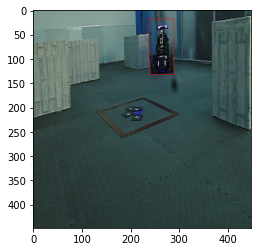

In [ ]:
Pred = Pred(model, img_root)
Pred.result()